Resized image saved as 'C:\Users\Lenovo\OneDrive\Desktop\seam carving\resized.jpg'
Seams visualization saved as 'C:\Users\Lenovo\OneDrive\Desktop\seam carving\seams_visualization.jpg'


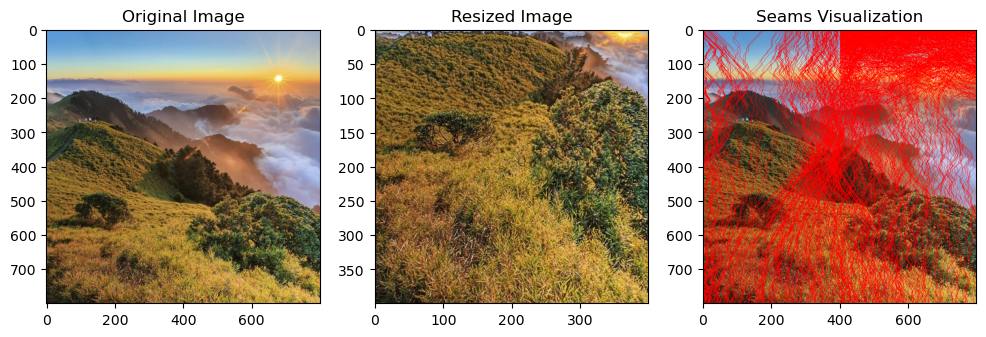

In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

filepath = r"C:\Users\Lenovo\OneDrive\Desktop\seam carving\seam.jpg"

def load_image(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: The file '{filepath}' was not found.")
    image = cv2.imread(filepath)
    if image is None:
        raise ValueError("Error: Unable to read the image.")
    return image

def compute_energy(gray):
    dx = np.abs(np.gradient(gray, axis=1))
    dy = np.abs(np.gradient(gray, axis=0))
    return dx + dy

def find_seam(energy):
    h, w = energy.shape
    seam_map = energy.copy()
    backtrack = np.zeros_like(seam_map, dtype=np.int32)
    
    for i in range(1, h):
        for j in range(w):
            left = seam_map[i - 1, j - 1] if j > 0 else np.inf
            up = seam_map[i - 1, j]
            right = seam_map[i - 1, j + 1] if j < w - 1 else np.inf
            min_energy = min(left, up, right)
            seam_map[i, j] += min_energy
            backtrack[i, j] = np.argmin([left, up, right]) - 1 + j
    
    seam = []
    j = np.argmin(seam_map[-1])
    for i in range(h - 1, -1, -1):
        seam.append(j)
        j = backtrack[i, j]
    
    return np.array(seam[::-1])

def remove_seam(image, seam):
    h, w, _ = image.shape
    new_image = np.zeros((h, w - 1, 3), dtype=np.uint8)
    for i in range(h):
        new_image[i, :, :] = np.delete(image[i, :, :], seam[i], axis=0)
    return new_image

def visualize_seams(image, vertical_seams, horizontal_seams):
    vis_image = image.copy()
    
    for seam in vertical_seams:
        for i in range(len(seam)):
            vis_image[i, seam[i]] = [0, 0, 255]
    
    vis_image_rotated = cv2.rotate(vis_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    for seam in horizontal_seams:
        for i in range(len(seam)):
            vis_image_rotated[i, seam[i]] = [0, 0, 255]
    
    vis_image = cv2.rotate(vis_image_rotated, cv2.ROTATE_90_CLOCKWISE)
    
    return vis_image

def seam_carving(image, num_seams):
    seams_removed = []
    for _ in range(num_seams):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        energy = compute_energy(gray)
        seam = find_seam(energy)
        seams_removed.append(seam)
        image = remove_seam(image, seam)
    return image, seams_removed

def resize_image(image, new_width, new_height):
    vertical_seams = []
    if new_width < image.shape[1]:
        image, vertical_seams = seam_carving(image, image.shape[1] - new_width)
    
    horizontal_seams = []
    if new_height < image.shape[0]:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        image, horizontal_seams = seam_carving(image, image.shape[1] - new_height)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    return image, vertical_seams, horizontal_seams

image = load_image(filepath)

new_width = image.shape[1] // 2
new_height = image.shape[0] // 2
resized_image, seams_v, seams_h = resize_image(image, new_width, new_height)

seam_visualization = visualize_seams(image, seams_v, seams_h)

output_resized = r"C:\Users\Lenovo\OneDrive\Desktop\seam carving\resized.jpg"
output_seams = r"C:\Users\Lenovo\OneDrive\Desktop\seam carving\seams_visualization.jpg"

cv2.imwrite(output_resized, resized_image)
cv2.imwrite(output_seams, seam_visualization)

print(f"Resized image saved as '{output_resized}'")
print(f"Seams visualization saved as '{output_seams}'")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("on")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis("on")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(seam_visualization, cv2.COLOR_BGR2RGB))
plt.title("Seams Visualization")
plt.axis("on")

plt.show()